In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("diabetes_binary_health_indicators_BRFSS2015.csv")
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [3]:
X_all = df[[feat for feat in df.columns if feat != "Diabetes_binary"]]
Y_all = df["Diabetes_binary"]

[Text(0, 0, '218334'), Text(0, 0, '35346')]

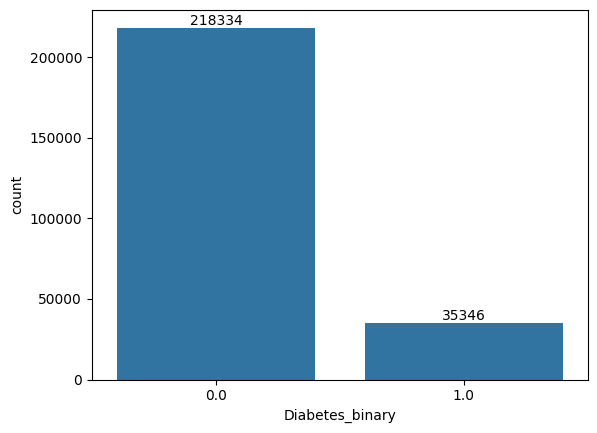

In [4]:
ax=sns.countplot(data=df, x="Diabetes_binary")
ax.bar_label(ax.containers[0])

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
# Dados reservados para validação final do modelo
X, X_test, Y, y_test = train_test_split(X_all, Y_all, test_size=0.1, random_state=416, stratify=Y_all)

[Text(0, 0, '196501'), Text(0, 0, '31811')]

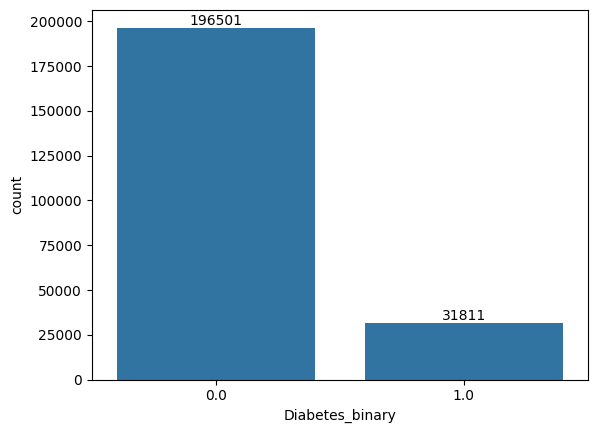

In [7]:
ax=sns.countplot(data=df.iloc[Y.index], x="Diabetes_binary")
ax.bar_label(ax.containers[0])

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

Fazendo testes de mudanças de parâmetros com auxílio de GridSearch

In [9]:
parameters = {
    'classifier__C':(0.01, .1,.5,1,5,10,100), 
    'classifier__penalty': ("l1", 'l2')
}

In [10]:
%%time
classifier = LogisticRegression(class_weight="balanced", max_iter=100000, solver='saga')
pipeline = Pipeline([
        ('smote', SMOTE(sampling_strategy=0.33, random_state=416)),
        ('classifier', classifier)
    ])
gridsearch = GridSearchCV(pipeline, parameters, cv=5, n_jobs=8, scoring="f1", verbose=0)
gridsearch.fit(X, Y)

CPU times: user 34.8 s, sys: 819 ms, total: 35.6 s
Wall time: 6min 46s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote',
                                        SMOTE(random_state=416,
                                              sampling_strategy=0.33)),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=100000,
                                                           solver='saga'))]),
             n_jobs=8,
             param_grid={'classifier__C': (0.01, 0.1, 0.5, 1, 5, 10, 100),
                         'classifier__penalty': ('l1', 'l2')},
             scoring='f1')

In [14]:
print(gridsearch.best_params_)

{'classifier__C': 1, 'classifier__penalty': 'l1'}


In [11]:
pd.DataFrame(gridsearch.cv_results_).sort_values(by=["mean_test_score"], ascending=False,).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,44.389249,2.928642,0.025567,0.003393,1,l1,"{'classifier__C': 1, 'classifier__penalty': 'l1'}",0.445749,0.449480,0.442946,0.443845,0.434457,0.443295,0.004956,1
7,41.467776,2.696890,0.024576,0.004051,1,l2,"{'classifier__C': 1, 'classifier__penalty': 'l2'}",0.445769,0.449410,0.442925,0.443845,0.434497,0.443289,0.004927,2
8,42.184971,4.188026,0.024048,0.002928,5,l1,"{'classifier__C': 5, 'classifier__penalty': 'l1'}",0.445769,0.449389,0.442925,0.443865,0.434497,0.443289,0.004922,3
10,43.215575,3.233191,0.024138,0.003352,10,l1,"{'classifier__C': 10, 'classifier__penalty': '...",0.445769,0.449389,0.442925,0.443865,0.434497,0.443289,0.004922,3
5,41.400325,2.349557,0.022635,0.002502,0.5,l2,"{'classifier__C': 0.5, 'classifier__penalty': ...",0.445769,0.449369,0.442966,0.443916,0.434425,0.443289,0.004943,5


Avaliando cutoff ótimo

In [15]:
from tqdm import tqdm
from sklearn.metrics import f1_score, matthews_corrcoef, roc_curve, roc_auc_score, \
                            classification_report ,confusion_matrix,balanced_accuracy_score, recall_score, precision_score, precision_recall_curve

In [16]:
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

In [17]:
mccs, balan_accs, f1s, cms = [],[],[], []
precisions, recalls = [],[]
tprs, fprs, aucs = [], [], []
mean_fpr = np.linspace(0, 1, 100)
for i in tqdm(range(1,101)):
    sm = SMOTE(sampling_strategy=0.33, random_state=416)
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=i, stratify=Y)
    X_train, Y_train = sm.fit_resample(X_train, Y_train)    
    clf = LogisticRegression(class_weight="balanced", max_iter=100000, solver='saga', C=1, penalty='l1', n_jobs=8)
    clf.fit(X_train, Y_train)
    y_pred_prob = clf.predict_proba(X_val)
    y_pred = to_labels(y_pred_prob, 0.5)[:, 1]
    mcc = matthews_corrcoef(Y_val, y_pred)
    mccs.append(mcc)
    balan_acc = balanced_accuracy_score(Y_val, y_pred)
    balan_accs.append(balan_acc)
    f1 = f1_score(Y_val, y_pred)
    precisions.append(precision_score(Y_val, y_pred))
    recalls.append(recall_score(Y_val, y_pred))
    f1s.append(f1)
    cms.append(confusion_matrix(Y_val, y_pred))
    fpr, tpr, thresholds = precision_recall_curve(Y_val, y_pred_prob[:, 1], pos_label=1, drop_intermediate=False)
    inter_tpr = np.interp(mean_fpr, fpr, tpr)
    tprs.append(inter_tpr); #fprs.append(fpr)
    aucs.append(roc_auc_score(Y_val, y_pred_prob[:, 1]))

100%|█████████████████████████████████████████| 100/100 [36:41<00:00, 22.01s/it]


In [18]:
print(f"ACC Balanceada: {np.mean(balan_accs):.4f} +- {np.std(balan_accs):.4f}")
print(f"ROC-AUC: {np.mean(aucs):.4f} +- {np.std(aucs):.4f}")
print(f"MCC: {np.mean(mccs):.4f} +- {np.std(mccs):.4f}")
print(f"F1: {np.mean(f1s):.4f} +- {np.std(f1s):.4f}")
print(f"Precision: {np.mean(precisions):.4f} +- {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} +- {np.std(recalls):.4f}")

ACC Balanceada: 0.7458 +- 0.0018
ROC-AUC: 0.8222 +- 0.0016
MCC: 0.3590 +- 0.0026
F1: 0.4432 +- 0.0018
Precision: 0.3121 +- 0.0015
Recall: 0.7643 +- 0.0040


<Axes: >

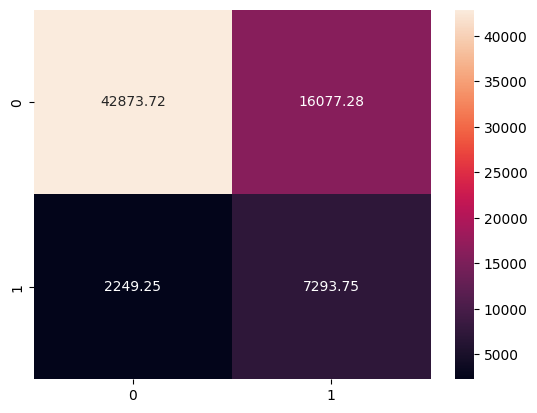

In [19]:
cms = np.array(cms)

sns.heatmap(cms.mean(axis=0), annot=True, fmt=".2f")

<Figure size 640x480 with 0 Axes>

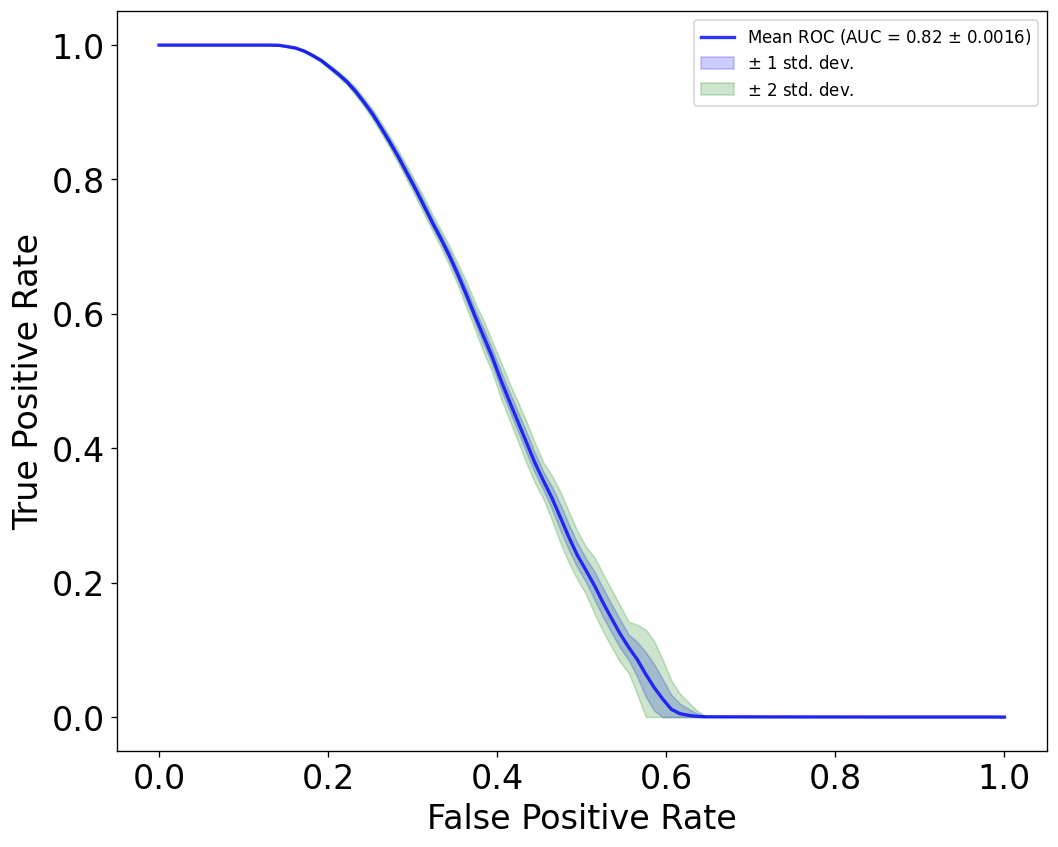

In [20]:
plt.figure()
# plt.style.use('seaborn-whitegrid')

lw = 2
plt.figure(figsize=(10, 8), dpi=120)

mean_tpr = np.mean(np.array(tprs), axis=0)
mean_fpr = np.linspace(0, 1, 100)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

plt.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.4f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

plt.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="blue",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr*2, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr*2, 0)

plt.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="green",
    alpha=0.2,
    label=r"$\pm$ 2 std. dev.",
)

# plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("False Positive Rate", fontsize=20)
plt.ylabel("True Positive Rate", fontsize=20)
# plt.title("Curva ROC", fontsize=20)
plt.legend(loc="upper right",prop={'size': 10})

Ajuste de cut-off point com F1-Score

In [21]:
thresholds = np.arange(0, 1, 0.01)
melhores_thresholds = []
mccs, balan_accs, f1s, cms = [],[],[], []
tprs, fprs, aucs = [], [], []
precisions, recalls = [], []
mean_fpr = np.linspace(0, 1, 100)
for i in tqdm(range(1,101)):
    sm = SMOTE(sampling_strategy=0.33, random_state=416)
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=i, stratify=Y)
    X_train, Y_train = sm.fit_resample(X_train, Y_train)
    clf = LogisticRegression(class_weight="balanced", max_iter=100000, solver='saga', C=1, penalty='l1', n_jobs=8)
    clf.fit(X_train, Y_train)
    # y_pred_proba_train = clf.predict_proba(X_train)
    y_pred_prob = clf.predict_proba(X_val)
    scores = [f1_score(Y_val, to_labels(y_pred_prob, t)[:, 1]) for t in thresholds]
    melhor_treshold = np.array(scores).argmax()
    melhores_thresholds.append(thresholds[melhor_treshold])
    # y_pred_prob = clf.predict_proba(X_val)
    y_pred = to_labels(y_pred_prob, thresholds[melhor_treshold])[:, 1]
    mcc = matthews_corrcoef(Y_val, y_pred)
    mccs.append(mcc)
    balan_acc = balanced_accuracy_score(Y_val, y_pred)
    balan_accs.append(balan_acc)
    f1 = f1_score(Y_val, y_pred)
    f1s.append(f1)
    precisions.append(precision_score(Y_val, y_pred))
    recalls.append(recall_score(Y_val, y_pred))
    cms.append(confusion_matrix(Y_val, y_pred))
    fpr, tpr, thresholds_ = roc_curve(Y_val, y_pred_prob[:, 1], pos_label=1, drop_intermediate=True)
    inter_tpr = np.interp(mean_fpr, fpr, tpr)
    tprs.append(inter_tpr); #fprs.append(fpr)
    aucs.append(roc_auc_score(Y_val, y_pred_prob[:, 1]))

100%|█████████████████████████████████████████| 100/100 [35:55<00:00, 21.56s/it]


In [22]:
print(f"ACC Balanceada: {np.mean(balan_accs):.4f} +- {np.std(balan_accs):.4f}")
print(f"ROC-AUC: {np.mean(aucs):.4f} +- {np.std(aucs):.4f}")
print(f"MCC: {np.mean(mccs):.4f} +- {np.std(mccs):.4f}")
print(f"F1: {np.mean(f1s):.4f} +- {np.std(f1s):.4f}")
print(f"Precision: {np.mean(precisions):.4f} +- {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} +- {np.std(recalls):.4f}")

ACC Balanceada: 0.7263 +- 0.0043
ROC-AUC: 0.8222 +- 0.0016
MCC: 0.3658 +- 0.0030
F1: 0.4613 +- 0.0024
Precision: 0.3634 +- 0.0070
Recall: 0.6323 +- 0.0182


In [23]:
print(f"Média do ponto de corte ótimo: {np.mean(melhores_thresholds)}")

Média do ponto de corte ótimo: 0.6182


<Axes: >

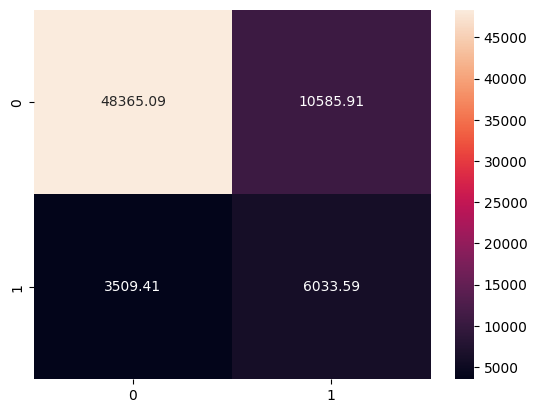

In [24]:
cms = np.array(cms)

sns.heatmap(cms.mean(axis=0), annot=True, fmt=".2f")

Ajuste de cut-off point com Acurácia Balanceada

In [25]:
thresholds = np.arange(0, 1, 0.01)
melhores_thresholds = []
mccs, balan_accs, f1s, cms = [],[],[], []
tprs, fprs, aucs = [], [], []
precisions, recalls = [], []
mean_fpr = np.linspace(0, 1, 100)
for i in tqdm(range(1,101)):
    sm = SMOTE(sampling_strategy=0.33, random_state=416)
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=i, stratify=Y)
    X_train, Y_train = sm.fit_resample(X_train, Y_train)
    clf = LogisticRegression(class_weight="balanced", max_iter=100000, solver='saga', C=1, penalty='l1', n_jobs=8)
    clf.fit(X_train, Y_train)
    # y_pred_proba_train = clf.predict_proba(X_train)
    y_pred_prob = clf.predict_proba(X_val)
    scores = [balanced_accuracy_score(Y_val, to_labels(y_pred_prob, t)[:, 1]) for t in thresholds]
    melhor_treshold = np.array(scores).argmax()
    melhores_thresholds.append(thresholds[melhor_treshold])
    # y_pred_prob = clf.predict_proba(X_val)
    y_pred = to_labels(y_pred_prob, thresholds[melhor_treshold])[:, 1]
    mcc = matthews_corrcoef(Y_val, y_pred)
    mccs.append(mcc)
    balan_acc = balanced_accuracy_score(Y_val, y_pred)
    balan_accs.append(balan_acc)
    f1 = f1_score(Y_val, y_pred)
    f1s.append(f1)
    precisions.append(precision_score(Y_val, y_pred))
    recalls.append(recall_score(Y_val, y_pred))
    cms.append(confusion_matrix(Y_val, y_pred))
    fpr, tpr, thresholds_ = roc_curve(Y_val, y_pred_prob[:, 1], pos_label=1, drop_intermediate=True)
    inter_tpr = np.interp(mean_fpr, fpr, tpr)
    tprs.append(inter_tpr); #fprs.append(fpr)
    aucs.append(roc_auc_score(Y_val, y_pred_prob[:, 1]))

100%|█████████████████████████████████████████| 100/100 [36:36<00:00, 21.97s/it]


In [26]:
print(f"ACC Balanceada: {np.mean(balan_accs):.4f} +- {np.std(balan_accs):.4f}")
print(f"ROC-AUC: {np.mean(aucs):.4f} +- {np.std(aucs):.4f}")
print(f"MCC: {np.mean(mccs):.4f} +- {np.std(mccs):.4f}")
print(f"F1: {np.mean(f1s):.4f} +- {np.std(f1s):.4f}")
print(f"Precision: {np.mean(precisions):.4f} +- {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} +- {np.std(recalls):.4f}")

ACC Balanceada: 0.7474 +- 0.0016
ROC-AUC: 0.8222 +- 0.0016
MCC: 0.3545 +- 0.0039
F1: 0.4346 +- 0.0050
Precision: 0.2986 +- 0.0066
Recall: 0.7990 +- 0.0151


In [27]:
print(f"Média do ponto de corte ótimo: {np.mean(melhores_thresholds)}")

Média do ponto de corte ótimo: 0.46270000000000006


<Axes: >

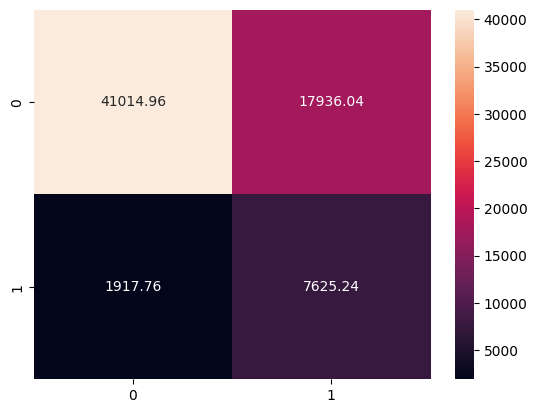

In [28]:
cms = np.array(cms)

sns.heatmap(cms.mean(axis=0), annot=True, fmt=".2f")

Ajuste de cut-off point com MCC

In [29]:
thresholds = np.arange(0, 1, 0.01)
melhores_thresholds = []
mccs, balan_accs, f1s, cms = [],[],[], []
tprs, fprs, aucs = [], [], []
precisions, recalls = [], []
mean_fpr = np.linspace(0, 1, 100)
for i in tqdm(range(1,101)):
    sm = SMOTE(sampling_strategy=0.33, random_state=416)
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=i, stratify=Y)
    X_train, Y_train = sm.fit_resample(X_train, Y_train)
    clf = LogisticRegression(class_weight="balanced", max_iter=100000, solver='saga', C=1, penalty='l1', n_jobs=8)
    clf.fit(X_train, Y_train)
    # y_pred_proba_train = clf.predict_proba(X_train)
    y_pred_prob = clf.predict_proba(X_val)
    scores = [matthews_corrcoef(Y_val, to_labels(y_pred_prob, t)[:, 1]) for t in thresholds]
    melhor_treshold = np.array(scores).argmax()
    melhores_thresholds.append(thresholds[melhor_treshold])
    # y_pred_prob = clf.predict_proba(X_val)
    y_pred = to_labels(y_pred_prob, thresholds[melhor_treshold])[:, 1]
    mcc = matthews_corrcoef(Y_val, y_pred)
    mccs.append(mcc)
    balan_acc = balanced_accuracy_score(Y_val, y_pred)
    balan_accs.append(balan_acc)
    f1 = f1_score(Y_val, y_pred)
    f1s.append(f1)
    precisions.append(precision_score(Y_val, y_pred))
    recalls.append(recall_score(Y_val, y_pred))
    cms.append(confusion_matrix(Y_val, y_pred))
    fpr, tpr, thresholds_ = roc_curve(Y_val, y_pred_prob[:, 1], pos_label=1, drop_intermediate=True)
    inter_tpr = np.interp(mean_fpr, fpr, tpr)
    tprs.append(inter_tpr); #fprs.append(fpr)
    aucs.append(roc_auc_score(Y_val, y_pred_prob[:, 1]))

100%|█████████████████████████████████████████| 100/100 [33:42<00:00, 20.22s/it]


In [30]:
print(f"ACC Balanceada: {np.mean(balan_accs):.4f} +- {np.std(balan_accs):.4f}")
print(f"ROC-AUC: {np.mean(aucs):.4f} +- {np.std(aucs):.4f}")
print(f"MCC: {np.mean(mccs):.4f} +- {np.std(mccs):.4f}")
print(f"F1: {np.mean(f1s):.4f} +- {np.std(f1s):.4f}")
print(f"Precision: {np.mean(precisions):.4f} +- {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} +- {np.std(recalls):.4f}")

ACC Balanceada: 0.7348 +- 0.0038
ROC-AUC: 0.8222 +- 0.0016
MCC: 0.3671 +- 0.0028
F1: 0.4596 +- 0.0029
Precision: 0.3494 +- 0.0078
Recall: 0.6727 +- 0.0193


In [31]:
print(f"Média do ponto de corte ótimo: {np.mean(melhores_thresholds)}")

Média do ponto de corte ótimo: 0.5867000000000001


<Axes: >

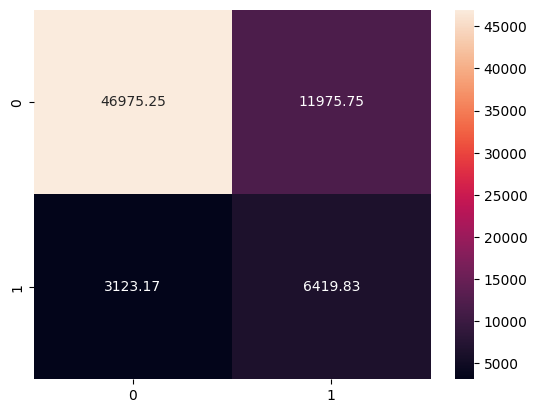

In [32]:
cms = np.array(cms)

sns.heatmap(cms.mean(axis=0), annot=True, fmt=".2f")